<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import model_selection

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


x_train.shape, x_test.shape

4422102/4422102 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
def plot_images(test_imgs, changed_imgs, n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_imgs[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(changed_imgs[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.show()

#Basic autoencoder

In [ ]:
class AutoEncoder(tf.keras.models.Model):
  def __init__(self, latent_dim, shape):
    super(AutoEncoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder  = tf.keras.Sequential([
        tf.keras.layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
        tf.keras.layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
shape = x_test.shape[1:]
latent_dim =  64
autoencoder= AutoEncoder(latent_dim, shape)

In [ ]:
autoencoder.compile(optimizer='adam',
                    loss=tf.keras.losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train,
                x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0236 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.008

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

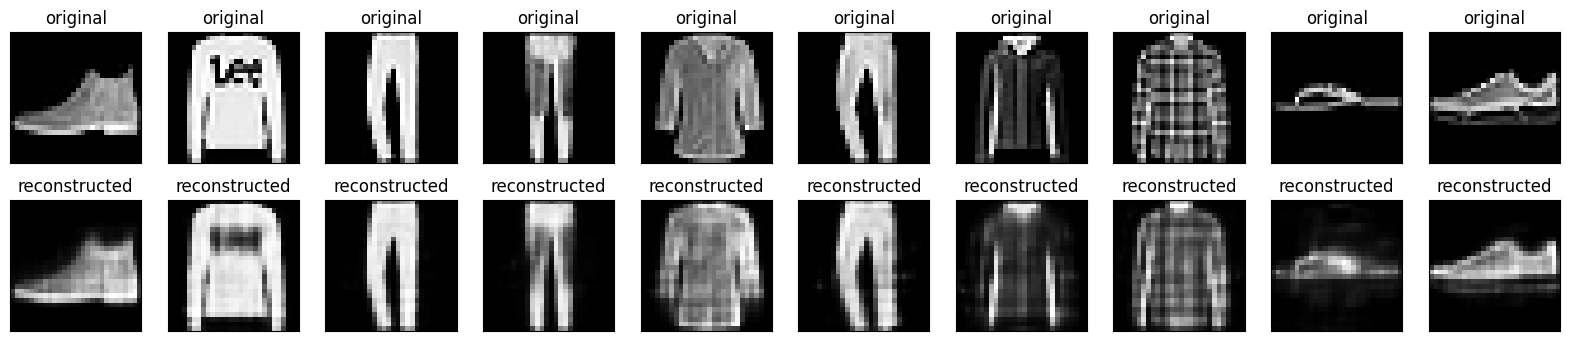

In [ ]:
plot_images(x_test, decoded_imgs, n=10)

# Image denoising

In [ ]:
#adding random noise to the images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy  = x_test  + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

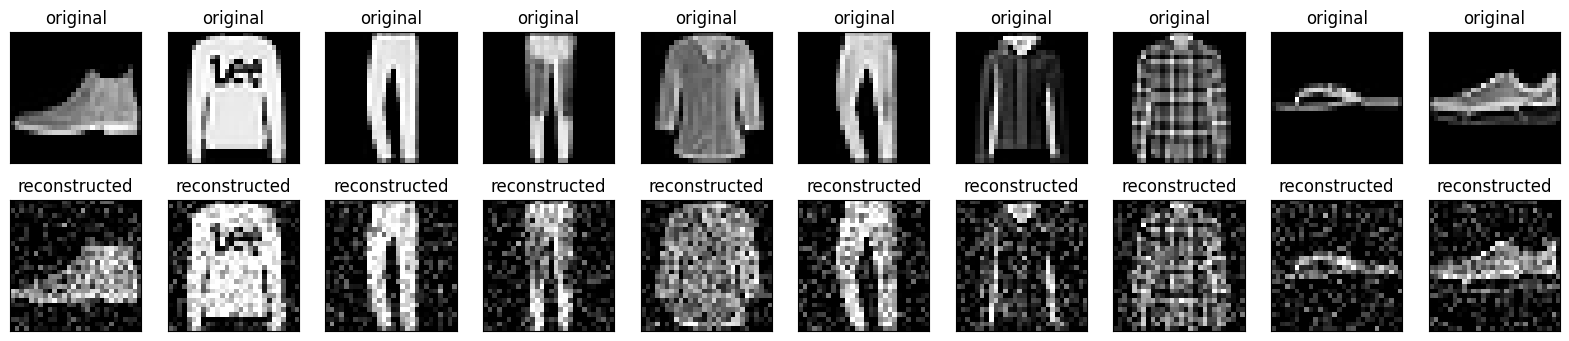

In [ ]:
plot_images(x_test, x_test_noisy, n=10)

convolutional autoencoder

In [ ]:
class Denoise(tf.keras.models.Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
        tf.keras.layers.Conv2D(8, 3,  activation='relu', padding='same', strides=2)
    ])
    self.decoder = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(8, 3, activation='relu', padding='same', strides=2),
        tf.keras.layers.Conv2DTranspose(16,3, activation='relu', padding='same', strides=2),
        tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam',
                    loss=tf.keras.losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy,
                x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
1875/1875 [==============================] - 58s 30ms/step - loss: 0.0178 - val_loss: 0.0098
Epoch 2/20
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 3/20
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 4/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/20
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/20
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/20
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 8/20
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 9/20
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/20
1875/1875 [==============================] - 54s 29m

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

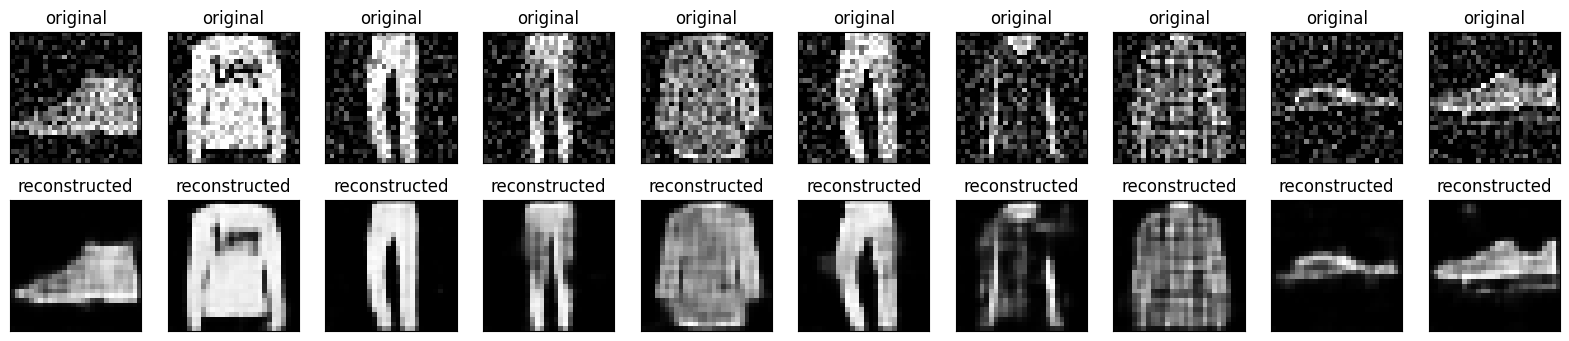

In [ ]:
plot_images(x_test_noisy, decoded_imgs, n=10)

#Image generation with diffusion models using Keras and TensorFlow


In [ ]:
def make_diffusion_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    for i in range(10):
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Conv2D(3, (1, 1), padding='same'))
    return model

def diffusion_process(x, timesteps=1000):
    for i in range(timesteps):
        noise = tf.random.normal(shape=x.shape)
        x = x + tf.math.sqrt(2.0 * 0.01) * noise
        x = x / tf.math.sqrt(1.0 + 2.0 * 0.01)
        x = make_diffusion_model()(x)
    return x

import tensorflow_datasets as tfds

def train_diffusion_model():
    dataset = tfds.load('cifar10', split='train', shuffle_files=True)
    dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    for epoch in range(100):
        for batch in dataset:
            with tf.GradientTape() as tape:
                noise = tf.random.normal(shape=batch['image'].shape)
                diffused_noise = diffusion_process(noise)
                logits = make_diffusion_model()(diffused_noise, training=True)
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(batch['image'], logits))
            gradients = tape.gradient(loss, make_diffusion_model().trainable_variables)
            optimizer.apply_gradients(zip(gradients, make_diffusion_model().trainable_variables))
        print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')


# Save the weights of the trained model
# model.save_weights('diffusion_model.h5')
# Load the saved weights into a new model object
# model = make_diffusion_model()
# train_diffusion_model()
# new_model.load_weights('diffusion_model.h5')

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset = tfds.load('cifar10', split='train', shuffle_files=True)
# dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

dataset
for epoch in range(10):
  for batch in dataset:
    with tf.GradientTape() as tape:
      noise = tf.random.normal(shape=batch['image'].shape)
      diffused_noise = diffusion_process(noise)
      logits = make_diffusion_model()(diffused_noise, training=True)
      loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(batch['image'], logits))
    gradients = tape.gradient(loss, make_diffusion_model().trainable_variables)
    optimizer.apply_gradients(zip(gradients, make_diffusion_model().trainable_variables))

In [ ]:
import matplotlib.pyplot as plt
def generate_samples():
    noise = tf.random.normal(shape=(1, 32, 32, 3))
    diffused_noise = diffusion_process(noise)
    model = make_diffusion_model()
    model.load_weights('diffusion_model.h5')
    for i in range(10):
        logits = model(diffused_noise, training=False)
        probs = tf.nn.softmax(logits)
        sample = tf.random.categorical(probs, num_samples=1)
        sample = tf.squeeze(sample, axis=-1)
        sample = tf.cast(sample, tf.float32) / 255.0
        diffused_noise = diffusion_process(sample)
        plt.imshow(sample.numpy())
        plt.show()

In [ ]:
def make_diffusion_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    for i in range(10):
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Conv2D(3, (1, 1), padding='same'))
    return model

def diffusion_process(x, timesteps=1000):
    for i in range(timesteps):
        noise = tf.random.normal(shape=x.shape)
        x = x + tf.math.sqrt(2.0 * 0.01) * noise
        x = x / tf.math.sqrt(1.0 + 2.0 * 0.01)
        x = make_diffusion_model()(x)
    return x

import tensorflow_datasets as tfds

def train_diffusion_model():
    dataset = tfds.load('cifar10', split='train', shuffle_files=True)
    dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    for epoch in range(100):
        for batch in dataset:
            with tf.GradientTape() as tape:
                noise = tf.random.normal(shape=batch['image'].shape)
                diffused_noise = diffusion_process(noise)
                logits = make_diffusion_model()(diffused_noise, training=True)
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(batch['image'], logits))
            gradients = tape.gradient(loss, make_diffusion_model().trainable_variables)
            optimizer.apply_gradients(zip(gradients, make_diffusion_model().trainable_variables))
        print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')

#Visualize

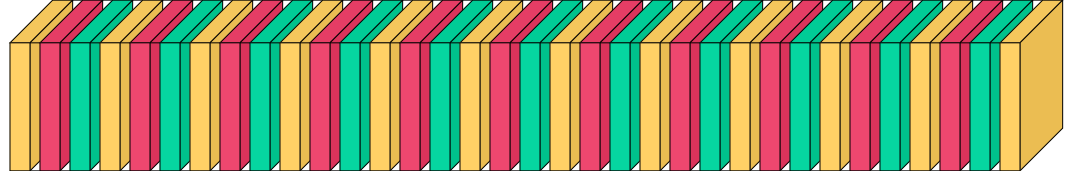

In [ ]:

def make_diffusion_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    for i in range(10):
        model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Conv2D(3, (1, 1), padding='same'))
    return model
model = make_diffusion_model()

# !pip install visualkeras

import visualkeras
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


import tensorboard
tensorboard.__version__

# Clear any logs from previous runs
!rm -rf ./logs/


# Define the model.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

(train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0


# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model.fit(
    train_images,
    train_labels,
    batch_size=64,
    epochs=5,
    callbacks=[tensorboard_callback])

%tensorboard --logdir logs

In [ ]:
# The function to be traced.
@tf.function
def my_func(x, y):
  # A simple hand-rolled layer.
  return tf.nn.relu(tf.matmul(x, y))

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Sample data for your function.
x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = my_func(x, y)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

%tensorboard --logdir logs/func

In [ ]:
!pip install keras_sequential_ascii

from keras_sequential_ascii import keras2ascii

model = make_diffusion_model()
keras2ascii(model)

In [ ]:
# !pip install netron
model.save_weights('weight.h5')
import netron
# netron(model)
netron.start('weight.h5')
# netron.start('[FILE]')

Serving 'weight.h5' at http://localhost:8081


('localhost', 8081)

In [ ]:
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=80,
    show_layer_activations=True,
    show_trainable=True)

In [ ]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=a1065f66906033fb22baf6db87b0e54310076ef52dbcb7e540c12829b7c4332a
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np                               # Import numpy
from skimage import data, io   # Import skimage library (data - Test images and example data.
from skimage.color import rgb2gray
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

In [ ]:
def construct_model():
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 1), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(12, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def sconstruct_model():
  smodel = Sequential()
  smodel.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
  smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  smodel.add(MaxPool2D((2, 2)))
  smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  smodel.add(MaxPool2D((2, 2)))
  smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  smodel.add(MaxPool2D((2, 2)))
  smodel.add(Flatten())
  smodel.add(Dense(256, activation='relu'))
  smodel.add(Dense(12, activation='softmax'))
  #optimizer = Adam(lr=0.001)
  smodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model.summary()
  return smodel

def cconstruct_model(learningRate):
  smodel = Sequential()
  smodel.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(128, 128, 1), activation='relu'))
  smodel.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
  smodel.add(MaxPool2D((2, 2)))
  smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  smodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  smodel.add(MaxPool2D((2, 2)))
  smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  smodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  smodel.add(MaxPool2D((2, 2)))
  smodel.add(Flatten())
  smodel.add(Dense(256, activation='relu'))
  smodel.add(Dense(256, activation='relu'))
  smodel.add(Dense(12, activation='softmax'))
  optimizer = Adam(learning_rate=learningRate)
  smodel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  smodel.summary()
  return smodel

model=cconstruct_model(0.001)
# model=construct_model()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_170 (Conv2D)         (None, 126, 126, 32)      320       
                                                                 
 conv2d_171 (Conv2D)         (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_172 (Conv2D)         (None, 60, 60, 64)        18496     
                                                                 
 conv2d_173 (Conv2D)         (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 29, 29, 64)        0         
 ng2D)                                               

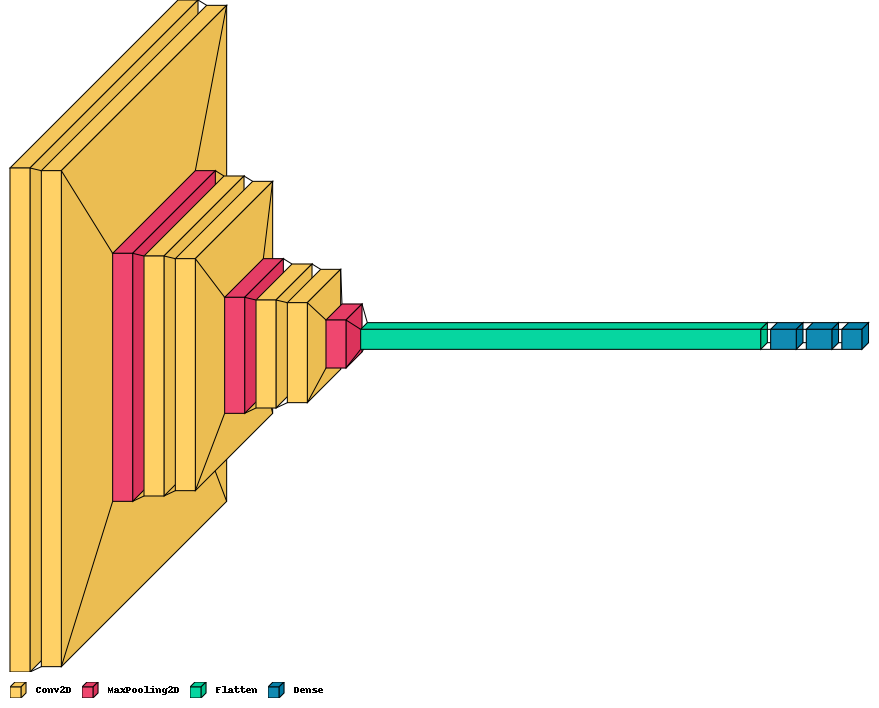

In [ ]:
model1=construct_model()
model2=sconstruct_model()
model3=cconstruct_model(0.009)
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model1, legend=True)
visualkeras.layered_view(model2, legend=True)
visualkeras.layered_view(model3, legend=True)

#dsgsrg

In [ ]:
# Loss Function for Diffusion Model
# Original Source: https://github.com/acids-ircam/diffusion_models

import torch
import numpy as np

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

def p_sample(model, x, t,alphas,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape,n_steps,alphas,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i,alphas,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt ,noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

def loss_variational(model, x_0,alphas_bar_sqrt, one_minus_alphas_bar_sqrt,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

def noise_estimation_loss(model, x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()


# Helper functions for plotting.
# Original Source: https://github.com/acids-ircam/diffusion_models

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from sklearn.mixture import GaussianMixture
import torch.distributions as distribution
from matplotlib.patches import Ellipse

def hdr_plot_style():
    plt.style.use('dark_background')
    mpl.rcParams.update({'font.size': 18, 'lines.linewidth': 3, 'lines.markersize': 15})
    # avoid type 3 (i.e. bitmap) fonts in figures
    mpl.rcParams['ps.useafm'] = True
    mpl.rcParams['pdf.use14corefonts'] = True
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = 'Courier New'
    # mpl.rcParams['text.hinting'] = False
    # Set colors cycle
    colors = mpl.cycler('color', ['#3388BB', '#EE6666', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
    #plt.rc('figure', facecolor='#00000000', edgecolor='black')
    #plt.rc('axes', facecolor='#FFFFFF88', edgecolor='white', axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('legend', facecolor='#666666EE', edgecolor='white', fontsize=16)
    plt.rc('grid', color='white', linestyle='solid')
    plt.rc('text', color='white')
    plt.rc('xtick', direction='out', color='white')
    plt.rc('ytick', direction='out', color='white')
    plt.rc('patch', edgecolor='#E6E6E6')

# define function that allows to generate a number of sub plots in a single line with the given titles
def prep_plots(titles, fig_size, fig_num=1):
    """
    create a figure with the number of sub_plots given by the number of totles, and return all generated subplot axis
    as a list
    """
    # first close possibly existing old figures, if you dont' do this Juyter Lab will coplain after a while when it collects more than 20 existing ficgires for the same cell
    # plt.close(fig_num)
    # create a new figure
    hdr_plot_style()
    fig=plt.figure(fig_num, figsize=fig_size)
    ax_list = []
    for ind, title in enumerate(titles, start=1):
        ax=fig.add_subplot(1, len(titles), ind)
        ax.set_title(title)
        ax_list.append(ax)
    return ax_list

def finalize_plots(axes_list, legend=True, fig_title=None):
    """
    adds grid and legend to all axes in the given list
    """
    if fig_title:
        fig = axes_list[0].figure
        fig.suptitle(fig_title, y=1)
    for ax in axes_list:
        ax.grid(True)
        if legend:
            ax.legend()

def plot_patterns(P,D):
    """ Plots the decision boundary of a single neuron with 2-dimensional inputs """
    hdr_plot_style()
    nPats = P.shape[1]
    nUnits = D.shape[0]
    if nUnits < 2:
        D = np.concatenate(D, np.zeros(1,nPats))
    # Create the figure
    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()
    # Calculate the bounds for the plot and cause axes to be drawn.
    xmin, xmax = np.min(P[0, :]), np.max(P[0, :])
    xb = (xmax - xmin) * 0.2
    ymin, ymax = np.min(P[1, :]), np.max(P[1, :])
    yb = (ymax-ymin) * 0.2
    ax.set(xlim=[xmin-xb, xmax+xb], ylim=[ymin-yb, ymax+yb])
    plt.title('Input Classification')
    plt.xlabel('x1'); plt.ylabel('x2')
    # classVal = 1 + D[1,:] + 2 * D[2,:];
    colors = [[0, 0.2, 0.9], [0, 0.9, 0.2], [0, 0, 1], [0, 1, 0]]
    symbols = 'ooo*+x'; Dcopy = D[:]
    #Dcopy[Dcopy == 0] = 1
    for i in range(nPats):
        c = Dcopy[i]
        ax.scatter(P[0,i], P[1,i], marker=symbols[c], c=colors[c], s=50, linewidths=2, edgecolor='w')
    #ax.legend()
    ax.grid(True)
    return fig

def plot_boundary(W,iVal,style,fig):
    """ Plots (bi-dimensionnal) input patterns """
    nUnits = W.shape[0]
    colors = plt.cm.inferno_r.colors[1::3]
    xLims = plt.gca().get_xlim()
    for i in range(nUnits):
        if len(style) == 1:
            color = [1, 1, 1];
        else:
            color = colors[int((3 * iVal + 9) % len(colors))]
        plt.plot(xLims,(-np.dot(W[i, 1], xLims) - W[i, 0]) / W[i, 2], linestyle=style, color=color, linewidth=1.5);
        fig.canvas.draw()

def visualize_boundary_linear(X, y, model):
# VISUALIZEBOUNDARYLINEAR plots a linear decision boundary learned by the SVM
#   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a linear decision boundary
#   learned by the SVM and overlays the data on it
    hdr_plot_style()
    w = model["w"]
    b = model["b"]
    xp = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100).transpose()
    yp = - (w[0] * xp + b) / w[1]
    plt.figure(figsize=(12, 8))
    pos = (y == 1)[:, 0]
    neg = (y == -1)[:, 0]
    plt.scatter(X[pos, 0], X[pos, 1], marker='x', linewidths=2, s=23, c=[0, 0.5, 0])
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', linewidths=2, s=23, c=[1, 0, 0])
    plt.plot(xp, yp, '-b')
    plt.scatter(model["X"][:, 0], model["X"][:, 1], marker='o', linewidths=4, s=40, c=None, edgecolors=[0.1, 0.1, 0.1])

def plot_data(X, y):
    #PLOTDATA Plots the data points X and y into a new figure
    #   PLOTDATA(x,y) plots the data points with + for the positive examples
    #   and o for the negative examples. X is assumed to be a Mx2 matrix.
    #
    # Note: This was slightly modified such that it expects y = 1 or y = 0
    hdr_plot_style()
    # Find Indices of Positive and Negative Examples
    pos = (y == 1)[:, 0]
    neg = (y == 0)[:, 0]
    # Plot Examples
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(X[pos, 0], X[pos, 1], marker='x', edgecolor='k', linewidths=2, s=50, c=[0, 0.5, 0])
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', edgecolor='k', linewidths=2, s=50, c=[1, 0, 0])
    return fig

def visualize_boundary(X, y, model):
    #VISUALIZEBOUNDARY plots a non-linear decision boundary learned by the SVM
    #   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a non-linear decision
    #   boundary learned by the SVM and overlays the data on it
    hdr_plot_style()
    # Plot the training data on top of the boundary
    plot_data(X, y)
    # Make classification predictions over a grid of values
    x1plot = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100).transpose()
    x2plot = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100).transpose()
    [X1, X2] = np.meshgrid(x1plot, x2plot)
    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.vstack((X1[:, i], X2[:, i]))
        vals[:, i] = svmPredict(model, this_X)
    # Plot the SVM boundary
    plt.contour(X1, X2, vals, [1, 1], c='b')
    # Plot the support vectors
    plt.scatter(model["X"][:, 0], model["X"][:, 1], marker='o', linewidths=4, s=10, c=[0.1, 0.1, 0.1])

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='w',
               levels=[-1, 0, 1], alpha=0.9,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=2, edgecolor='w', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def plot_gaussian_ellipsoid(m, C, sdwidth=1, npts=None, axh=None, color='r'):
    # PLOT_GAUSSIAN_ELLIPSOIDS plots 2-d and 3-d Gaussian distributions
    #
    # H = PLOT_GAUSSIAN_ELLIPSOIDS(M, C) plots the distribution specified by
    #  mean M and covariance C. The distribution is plotted as an ellipse (in
    #  2-d) or an ellipsoid (in 3-d).  By default, the distributions are
    #  plotted in the current axes.

    # PLOT_GAUSSIAN_ELLIPSOIDS(M, C, SD) uses SD as the standard deviation
    #  along the major and minor axes (larger SD => larger ellipse). By
    #  default, SD = 1.
    # PLOT_GAUSSIAN_ELLIPSOIDS(M, C, SD, NPTS) plots the ellipse or
    #  ellipsoid with a resolution of NPTS
    #
    # PLOT_GAUSSIAN_ELLIPSOIDS(M, C, SD, NPTS, AX) adds the plot to the
    #  axes specified by the axis handle AX.
    #
    # Examples:
    # -------------------------------------------
    #  # Plot three 2-d Gaussians
    #  figure;
    #  h1 = plot_gaussian_ellipsoid([1 1], [1 0.5; 0.5 1]);
    #  h2 = plot_gaussian_ellipsoid([2 1.5], [1 -0.7; -0.7 1]);
    #  h3 = plot_gaussian_ellipsoid([0 0], [1 0; 0 1]);
    #  set(h2,'color','r');
    #  set(h3,'color','g');
    #
    #  # "Contour map" of a 2-d Gaussian
    #  figure;
    #  for sd = [0.3:0.4:4],
    #    h = plot_gaussian_ellipsoid([0 0], [1 0.8; 0.8 1], sd);
    #  end
    #
    #  # Plot three 3-d Gaussians
    #  figure;
    #  h1 = plot_gaussian_ellipsoid([1 1  0], [1 0.5 0.2; 0.5 1 0.4; 0.2 0.4 1]);
    #  h2 = plot_gaussian_ellipsoid([1.5 1 .5], [1 -0.7 0.6; -0.7 1 0; 0.6 0 1]);
    #  h3 = plot_gaussian_ellipsoid([1 2 2], [0.5 0 0; 0 0.5 0; 0 0 0.5]);
    #  set(h2,'facealpha',0.6);
    #  view(129,36); set(gca,'proj','perspective'); grid on;
    #  grid on; axis equal; axis tight;
    # -------------------------------------------
    #
    #  Gautam Vallabha, Sep-23-2007, Gautam.Vallabha@mathworks.com

    #  Revision 1.0, Sep-23-2007
    #    - File created
    #  Revision 1.1, 26-Sep-2007
    #    - NARGOUT==0 check added.
    #    - Help added on NPTS for ellipsoids

    if axh is None:
        axh = plt.gca()
    if m.size != len(m):
        raise Exception('M must be a vector');
    if (m.size == 2):
        h = show2d(m[:], C, sdwidth, npts, axh, color)
    elif (m.size == 3):
        h = show3d(m[:], C, sdwidth, npts, axh, color)
    else:
        raise Exception('Unsupported dimensionality');
    return h

#-----------------------------
def show2d(means, C, sdwidth, npts=None, axh=None, color='r'):
    if (npts is None):
        npts = 50
    # plot the gaussian fits
    tt = np.linspace(0, 2 * np.pi, npts).transpose()
    x = np.cos(tt);
    y = np.sin(tt);
    ap = np.vstack((x[:], y[:])).transpose()
    v, d = np.linalg.eigvals(C)
    d = sdwidth / np.sqrt(d) # convert variance to sdwidth*sd
    bp = np.dot(v, np.dot(d, ap)) + means
    h = axh.plot(bp[:, 0], bp[:, 1], ls='-', color=color)
    return h

#-----------------------------
def show3d(means, C, sdwidth, npts=None, axh=None):
    if (npts is None):
        npts = 20
    x, y, z = sphere(npts);
    ap = np.concatenate((x[:], y[:], z[:])).transpose()
    v, d = eigvals(C)
    if any(d[:] < 0):
        print('warning: negative eigenvalues')
        d = np.max(d, 0)
    d = sdwidth * np.sqrt(d); # convert variance to sdwidth*sd
    bp = (v * d * ap) + repmat(means, 1, size(ap,2));
    xp = reshape(bp[0,:], size(x));
    yp = reshape(bp[1,:], size(y));
    zp = reshape(bp[2,:], size(z));
    h = axh.surf(xp, yp, zp);
    return h

def fit_multivariate_gaussian(X_s):
    gmm = GaussianMixture(n_components=1).fit(X_s)
    labels = gmm.predict(X_s)
    N = 50
    X = np.linspace(-2, 10, N)
    Y = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    norm = distribution.MultivariateNormal(torch.Tensor(gmm.means_[0]), torch.Tensor(gmm.covariances_[0]))
    Z = torch.exp(norm.log_prob(torch.Tensor(pos))).numpy()
    plt.figure(figsize=(10, 8));
    ax = plt.gca()
    cset = ax.contourf(X, Y, Z, cmap='magma')
    plt.scatter(X_s[:, 0], X_s[:, 1], c='b', s=60, edgecolor='w', zorder=2.5); plt.grid(True);
    return labels

def fit_gaussian_mixture(X_s):
    gmm = GaussianMixture(n_components=4).fit(X_s)
    labels = gmm.predict(X_s)
    N = 50
    X = np.linspace(-2, 10, N)
    Y = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = np.zeros((pos.shape[0], pos.shape[1]))
    for i in range(4):
        norm = distribution.MultivariateNormal(torch.Tensor(gmm.means_[i]), torch.Tensor(gmm.covariances_[i]))
        Z += torch.exp(norm.log_prob(torch.Tensor(pos))).numpy()
    plt.figure(figsize=(10, 8));
    ax = plt.gca()
    cset = ax.contourf(X, Y, Z, cmap='magma')
    plt.scatter(X_s[:, 0], X_s[:, 1], c='b', s=60, edgecolor='w', zorder=2.5); plt.grid(True);
    return labels

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize=(10,8))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='magma', edgecolor='gray', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.4 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


#An Implementation of Diffusion Network Model
#Oringinal source: https://github.com/acids-ircam/diffusion_models

import torch.nn as nn
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

# Exponential Moving Average Class
# Orignal source: https://github.com/acids-ircam/diffusion_models


class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

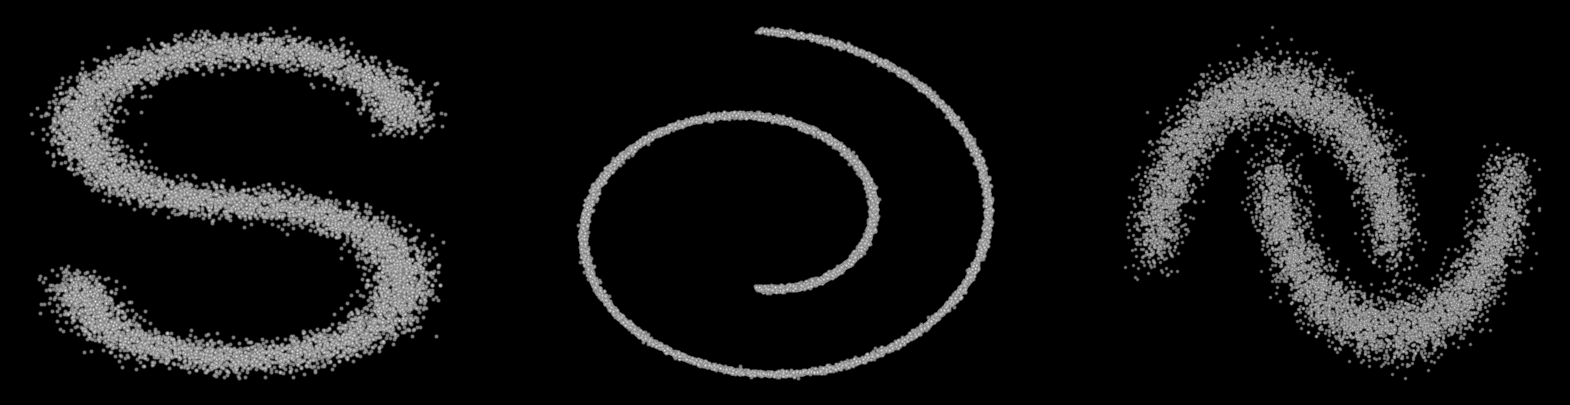

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
# from helper_plot import hdr_plot_style
import torch
# from utils import *

hdr_plot_style()
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T
#dataset = torch.Tensor(data.T).float()


fig,axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[0].axis('off')

data = swiss_roll.T
axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[1].axis('off')
#dataset = torch.Tensor(data.T).float()

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
axes[2].axis('off')
dataset = torch.Tensor(data.T).float()

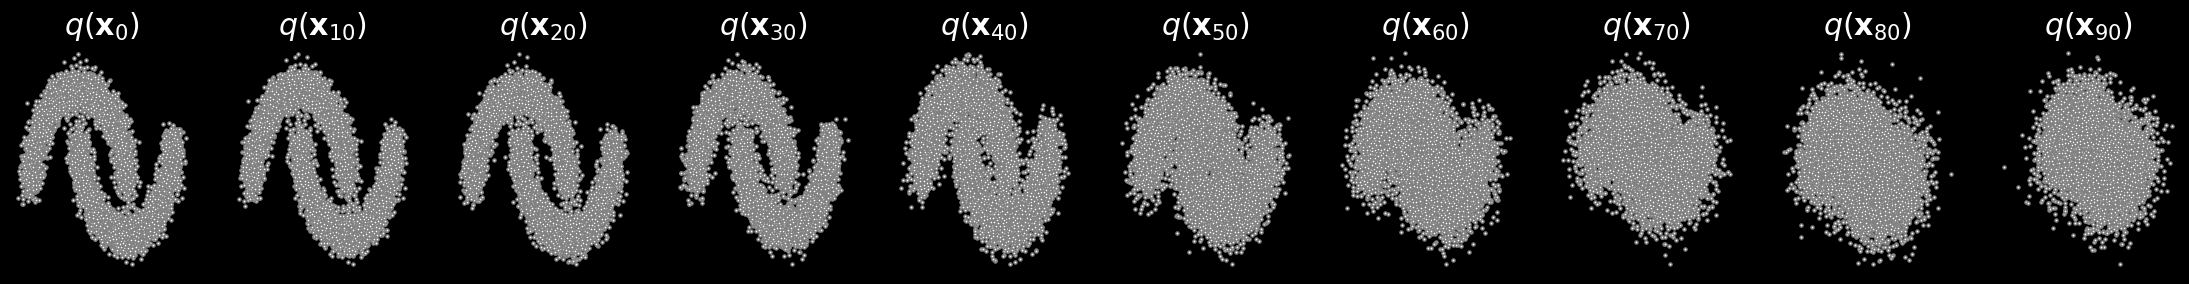

In [ ]:
num_steps = 100
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [ ]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

tensor(0.7958, grad_fn=<MeanBackward0>)
tensor(0.9527, grad_fn=<MeanBackward0>)
tensor(0.7496, grad_fn=<MeanBackward0>)
tensor(0.8753, grad_fn=<MeanBackward0>)
tensor(0.8703, grad_fn=<MeanBackward0>)
tensor(0.6128, grad_fn=<MeanBackward0>)
tensor(0.6602, grad_fn=<MeanBackward0>)
tensor(0.8069, grad_fn=<MeanBackward0>)
tensor(0.9591, grad_fn=<MeanBackward0>)
tensor(1.0213, grad_fn=<MeanBackward0>)


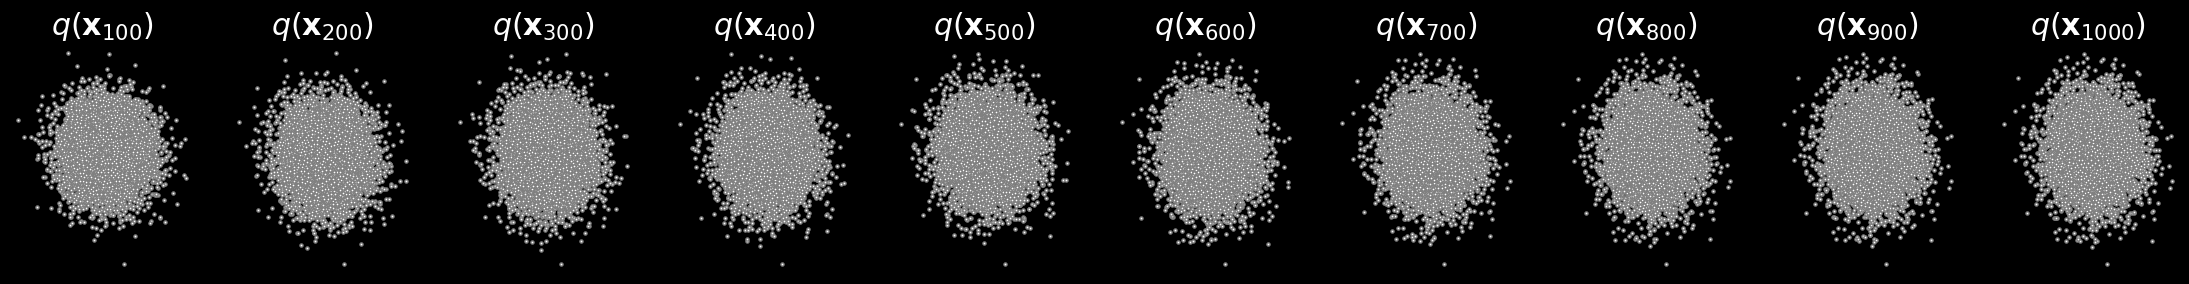

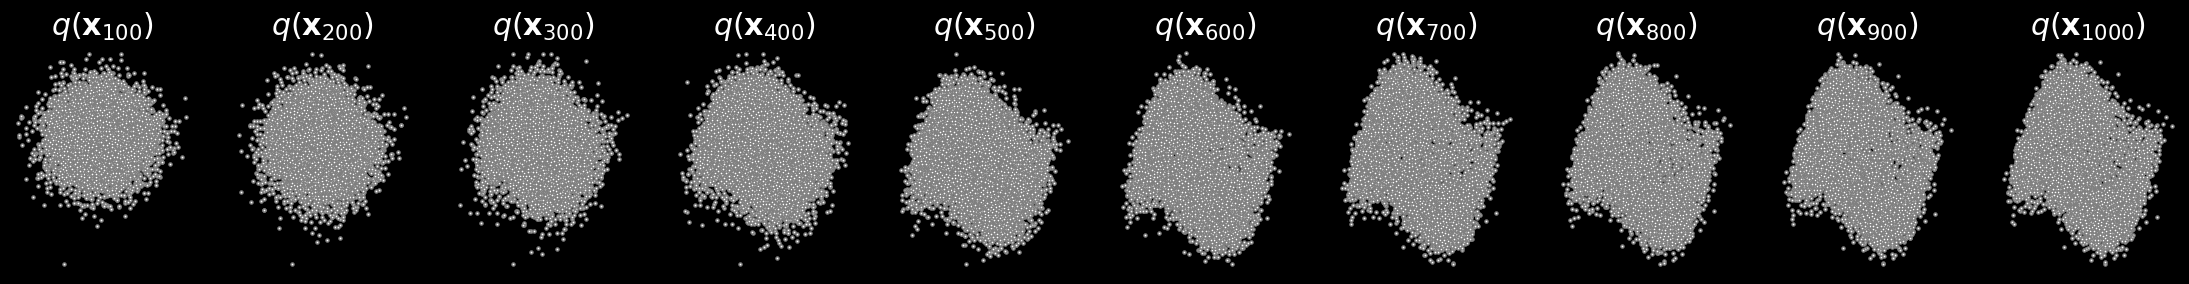

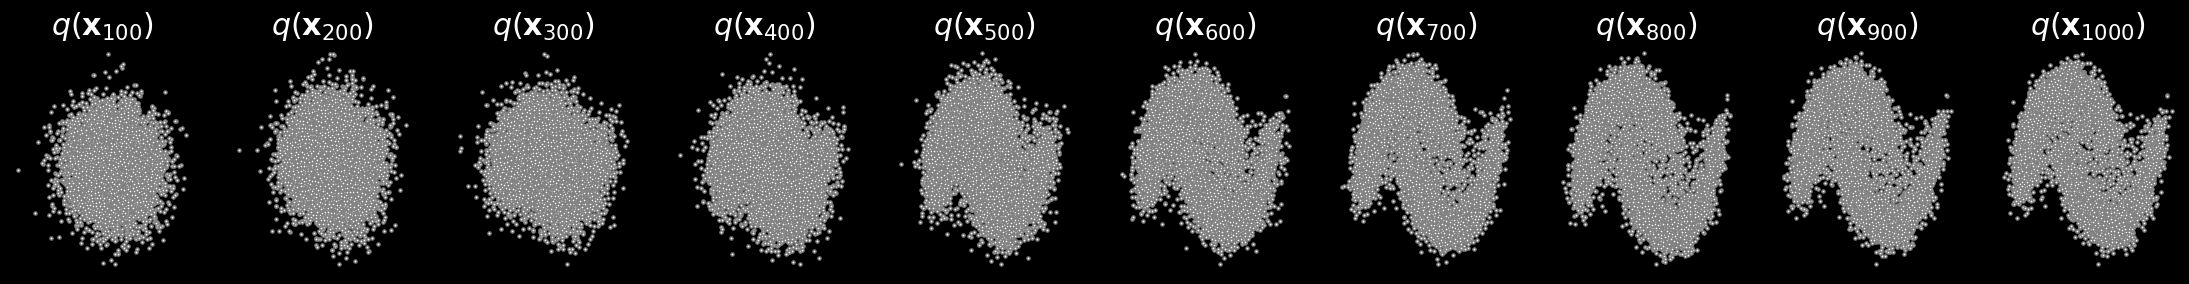

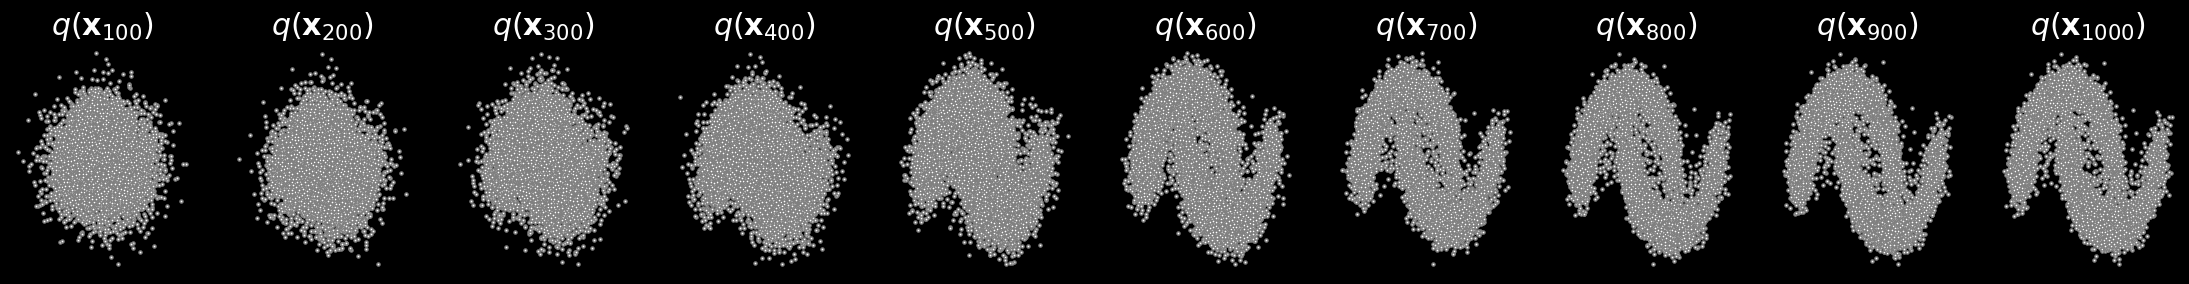

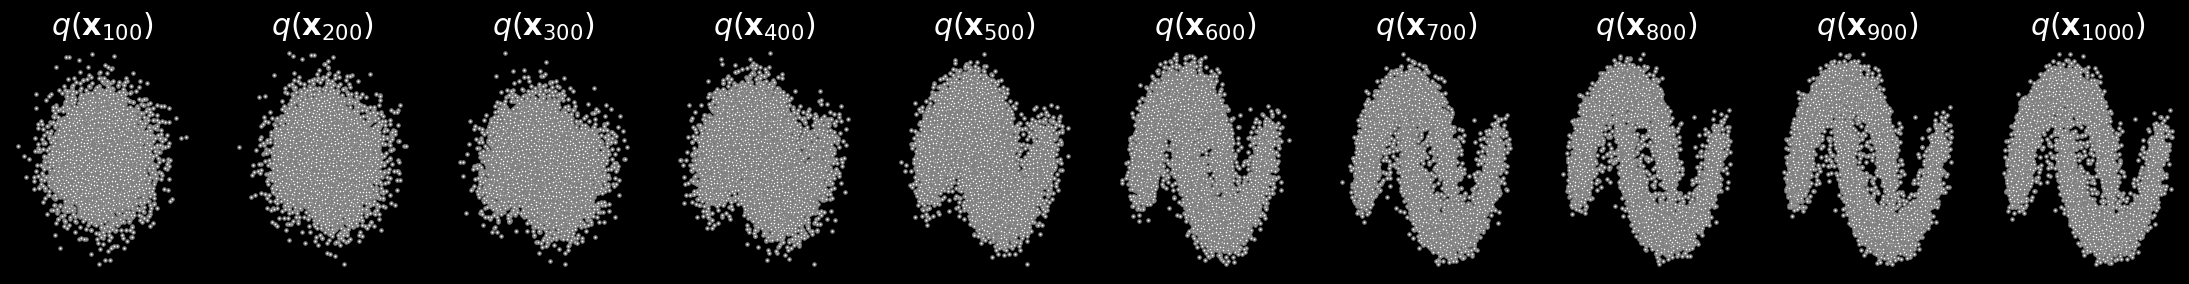

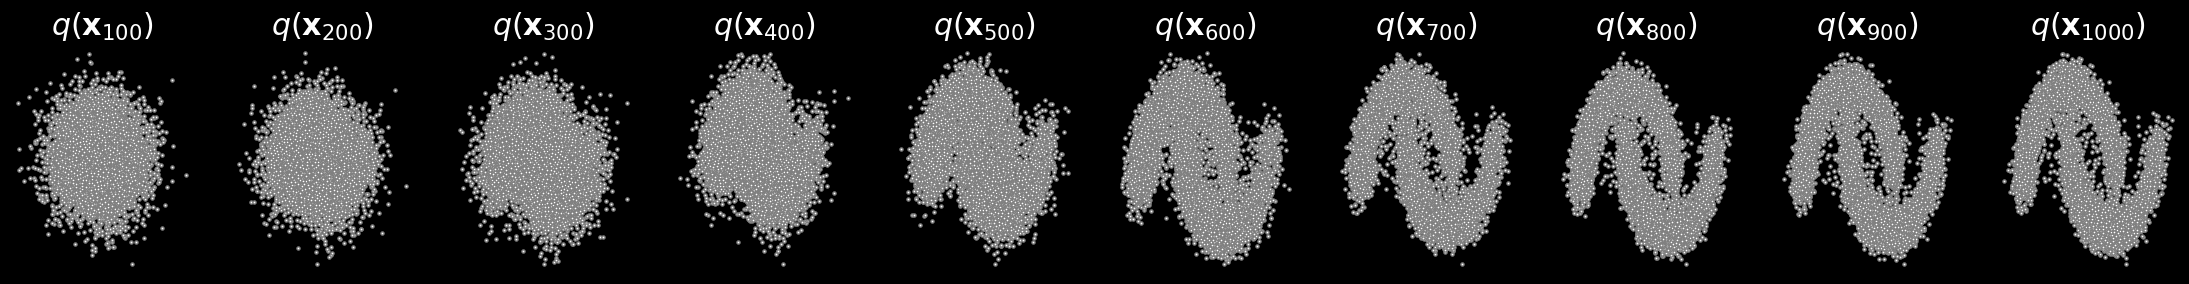

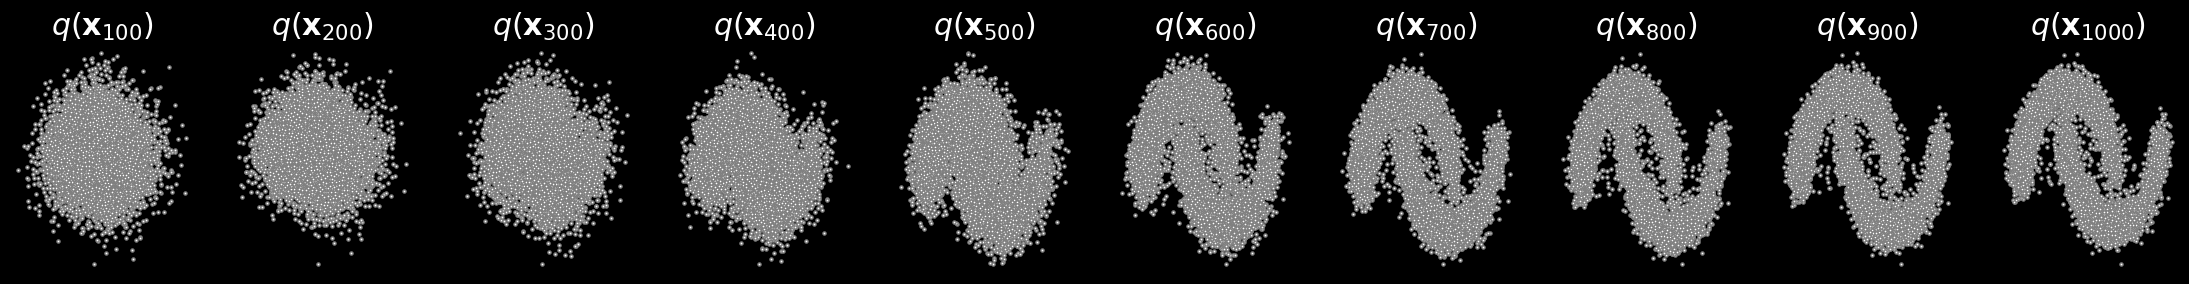

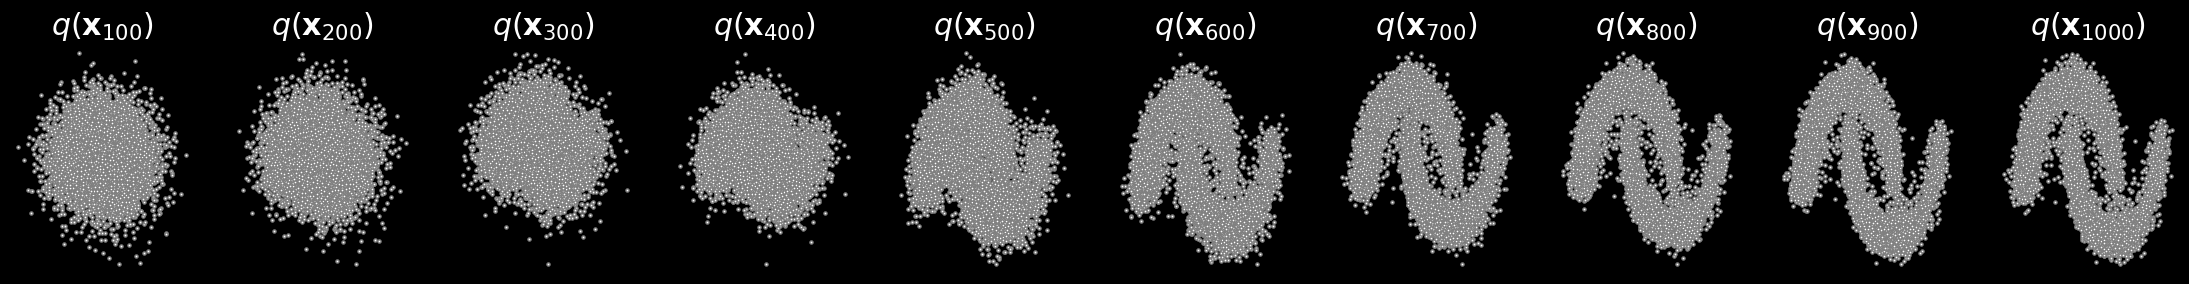

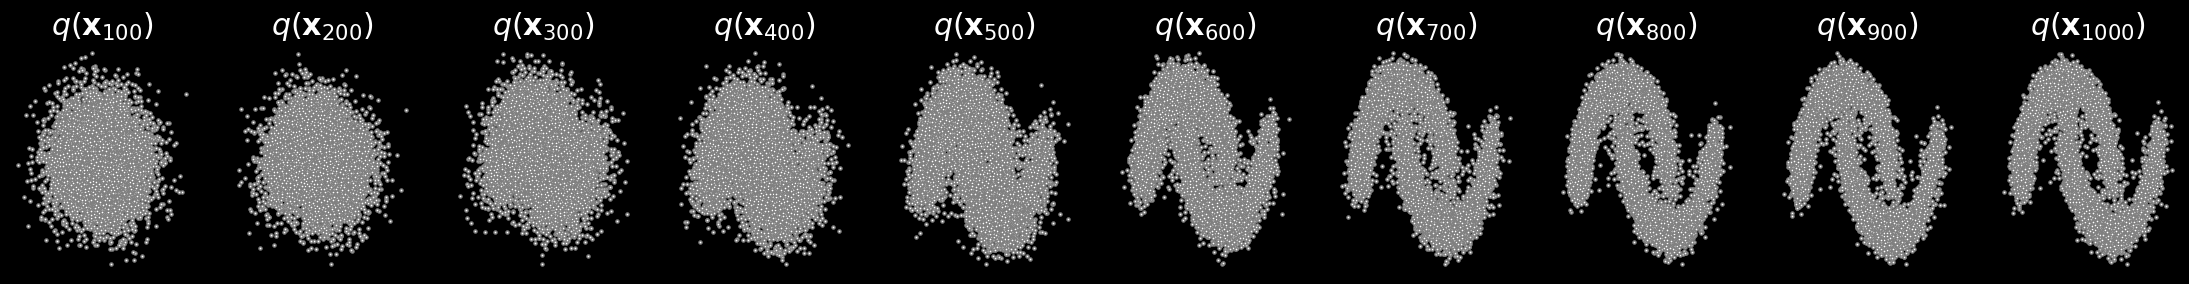

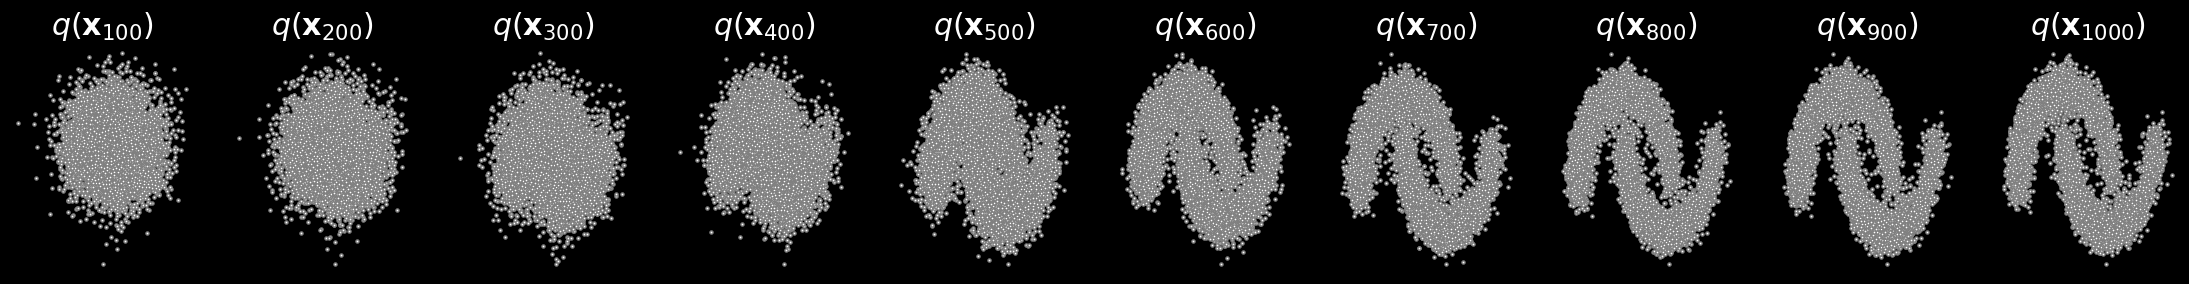

In [ ]:
# from model import ConditionalModel
# from ema import EMA
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

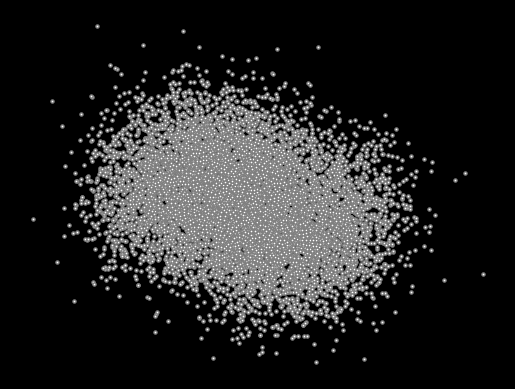

In [ ]:
# Generating the forward image sequence

import io
from PIL import Image

imgs = []
#fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    plt.axis('off');

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)

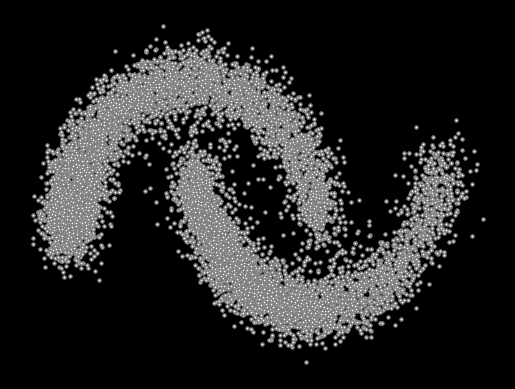

In [ ]:
# Generating the reverse diffusion sequence

reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)
imgs = imgs + reverse
imgs[0].save("diffusion.gif", format='GIF', append_images=imgs,save_all=True, duration=100, loop=0)

#dddd

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
clear_output()

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteBDNQ65/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteBDNQ65/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

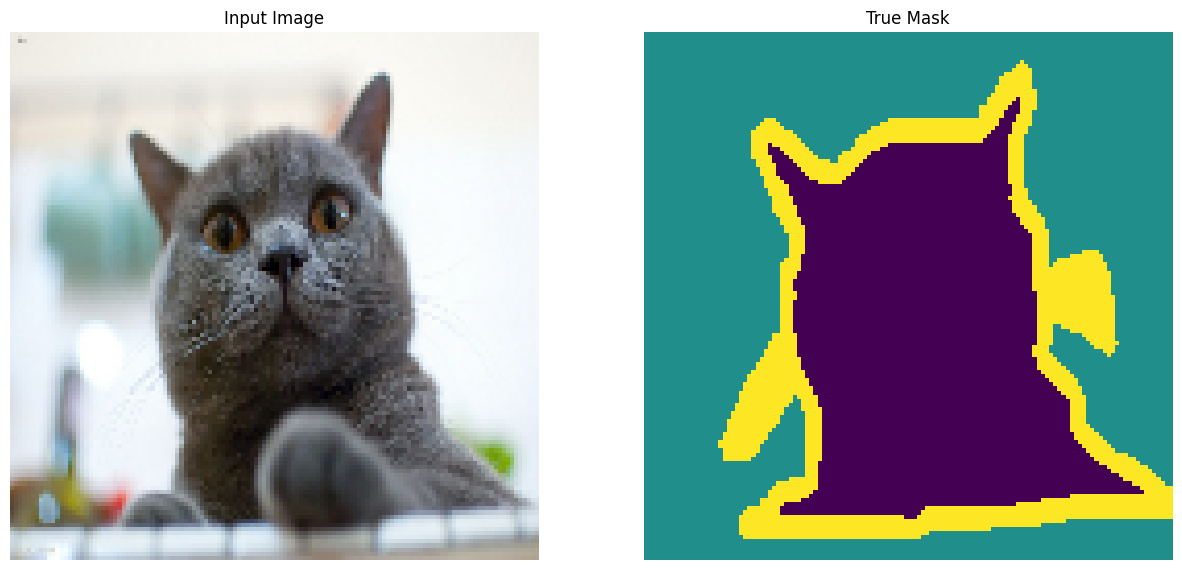

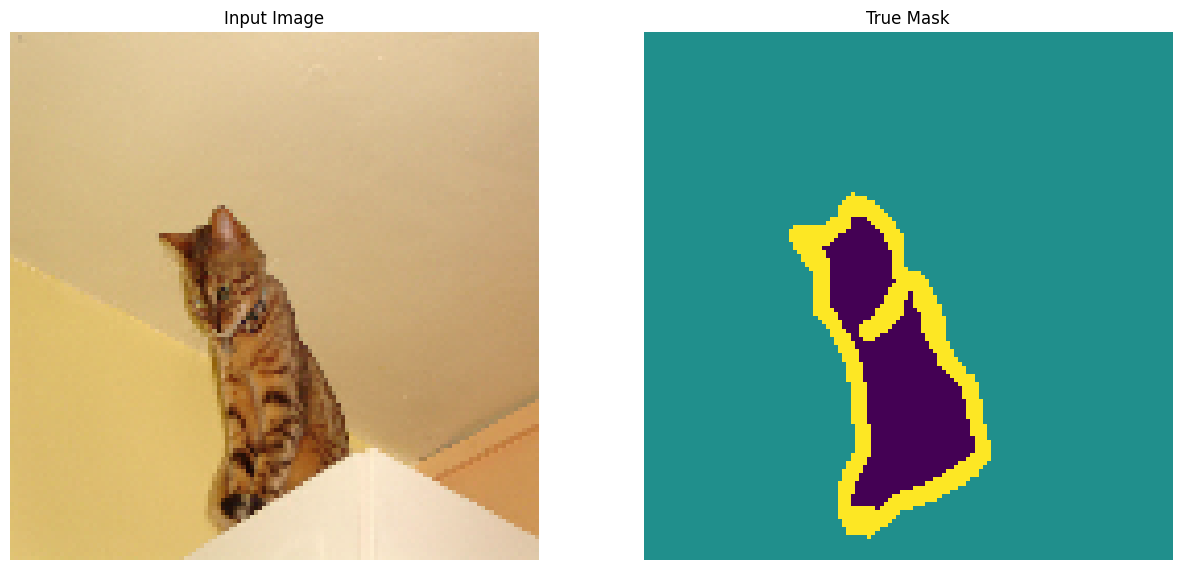

In [6]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [8]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [9]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2, padding='same')  #64x64 -> 128x128
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

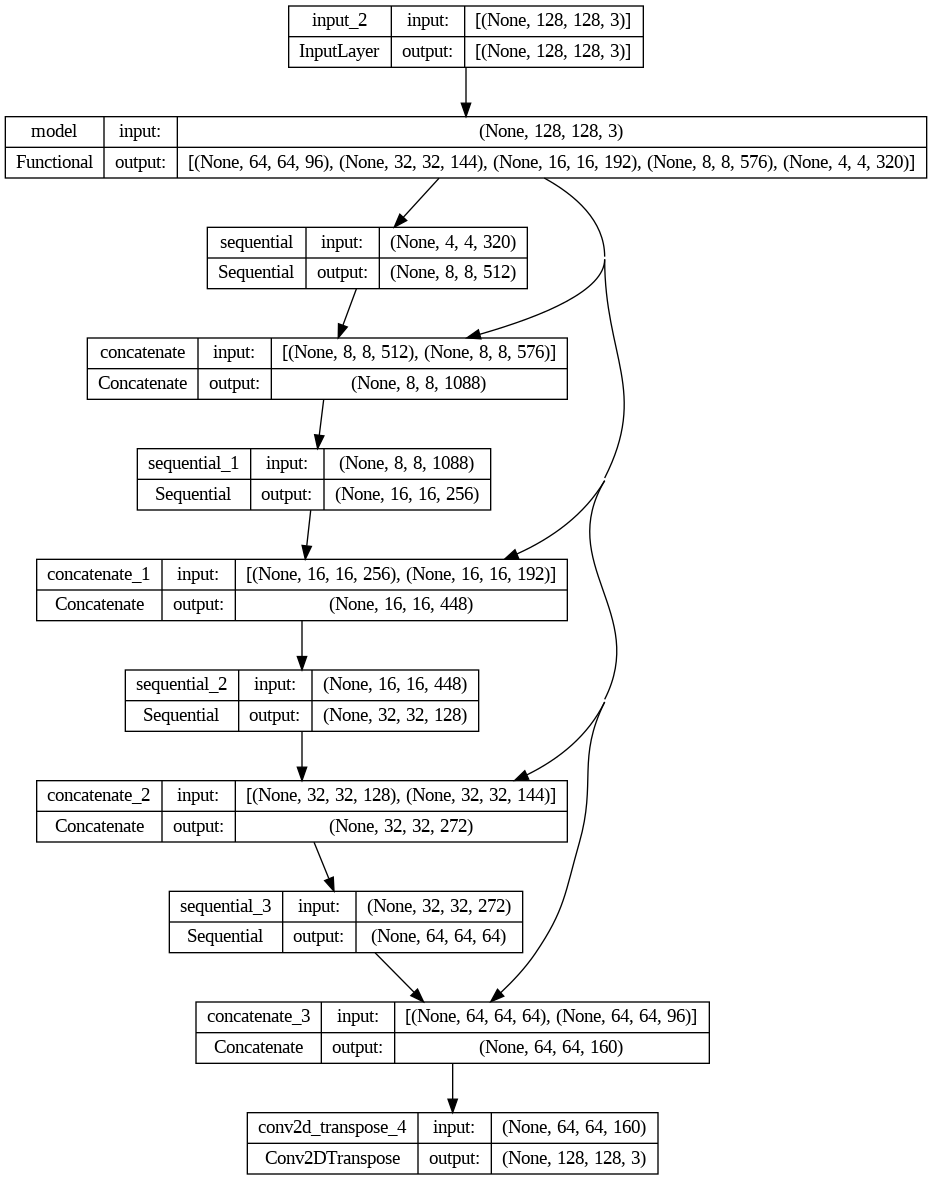

In [10]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

1/1 [==============================] - 2s 2s/step


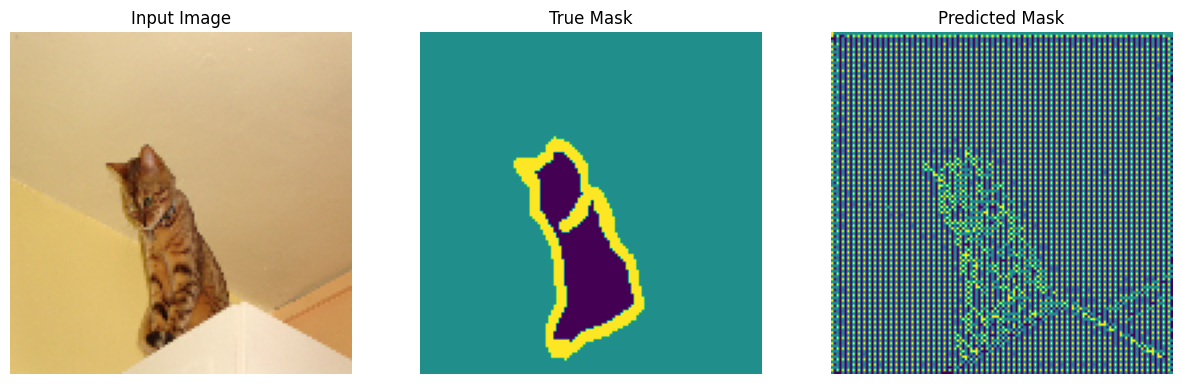

In [11]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

1/1 [==============================] - 0s 62ms/step


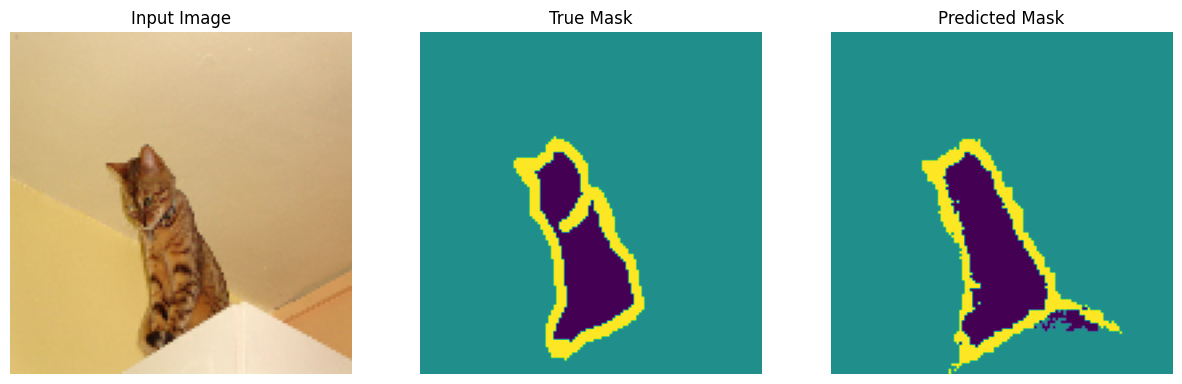


Sample Prediction after epoch 2

57/57 [==============================] - 378s 7s/step - loss: 0.2915 - accuracy: 0.8893 - val_loss: 0.3051 - val_accuracy: 0.8881


In [14]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

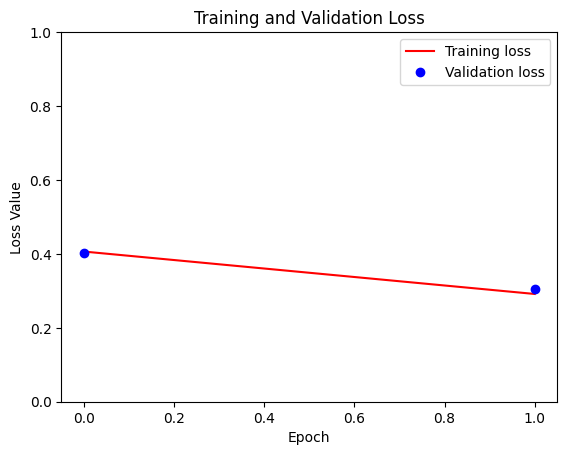

In [15]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 3s 1s/step


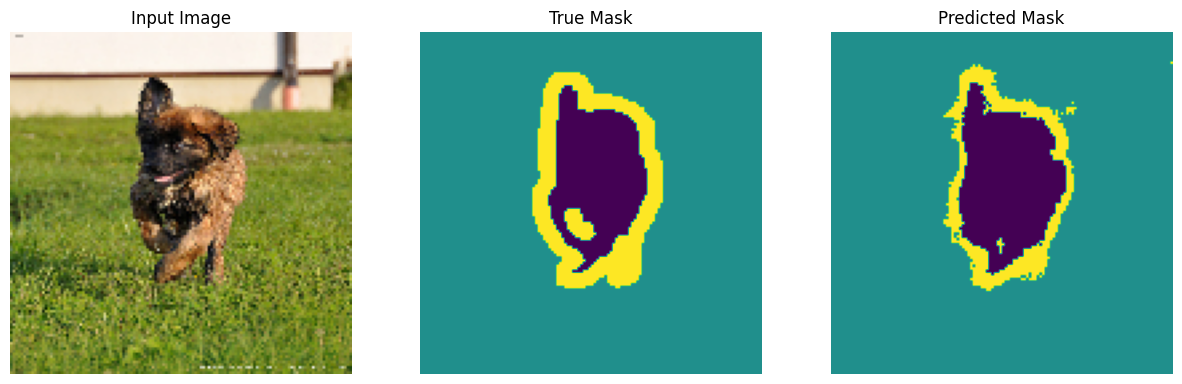

2/2 [==============================] - 3s 1s/step


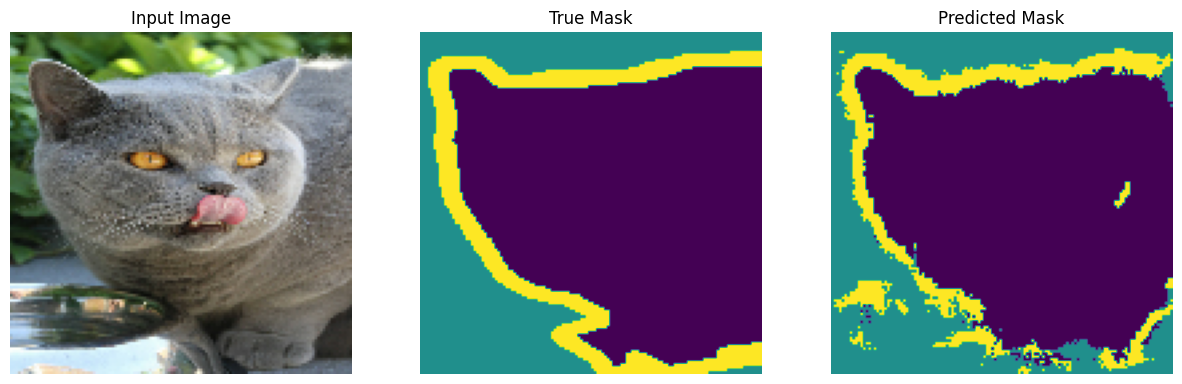

2/2 [==============================] - 2s 1s/step


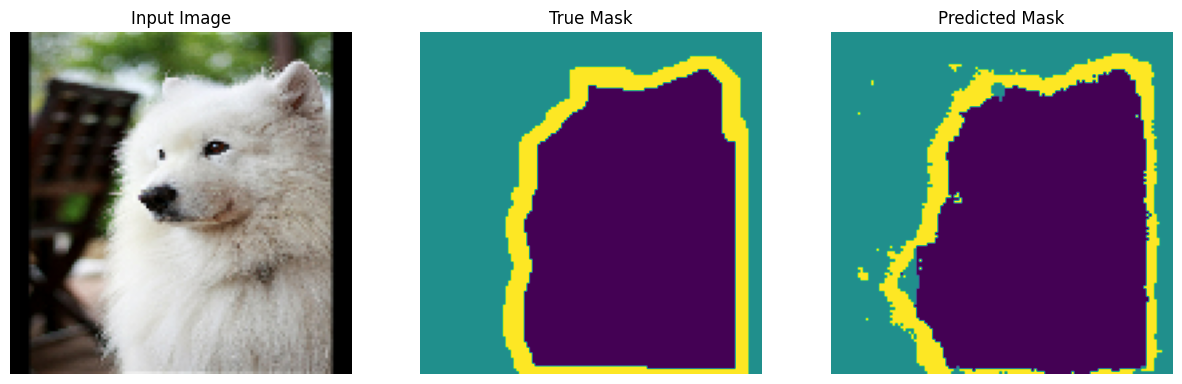

In [16]:
show_predictions(test_batches, 3)


In [17]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/2
57/57 [==============================] - 341s 6s/step - loss: 0.4139 - accuracy: 0.8885
Epoch 2/2
57/57 [==============================] - 331s 6s/step - loss: 0.3861 - accuracy: 0.8944
Expected AssertionError: 


In [18]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

In [19]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [21]:
train_batches.map(add_sample_weights).element_spec

weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 65s 6s/step - loss: 0.2896 - accuracy: 0.6382
